<h1>Заказ такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. 

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Описание данных**

Файл с данными:

`/datasets/taxi.csv`

Признаки:

- `num_orders` — количество заказов

Целевой признак:

- `datetime` — время заказа

<h2>Загрузка данных

Импортируем необходимые библиотеки для работы. Считаем данные из csv-файла в переменную `df`.

Установим индекс таблицы равный столбцу `datetime` и преобразим его в тип данных `datetime` с помощью методов `index_col=[0]` и `parse_dates=[0]`.

Выполним ресемплирование данных по одному часу.

Изучим данные.

In [2]:
# импорты из стандартной библиотеки
import math
import optuna
import warnings

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# импорты модулей текущего проекта
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

# настройки
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_colwidth', None)

# константа
SEED = 12345

In [3]:
try:
    df = pd.read_csv('C:/jupyter projects/15 sprint/taxi.csv', 
                     index_col=[0], 
                     parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', 
                     index_col=[0], 
                     parse_dates=[0])

Отсортируем индексы таблицы и проверим, расположены ли в хронологическом порядке даты.

In [4]:
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

True

Всё хорошо.

Выполним ресемплинг.

In [5]:
df = df.resample('1H').sum()

Взглянем на общую информацию таблицы.

In [6]:
def names(x, y):
    plt.xlabel(x)
    plt.ylabel(y)

Размерность таблицы: (4416, 1)

Количество пропусков:
num_orders    0
dtype: int64

Временной промежуток: 183 days 23:00:00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


None

<Axes: title={'center': 'Заказы такси'}, xlabel='Месяц', ylabel='Заказы'>

None

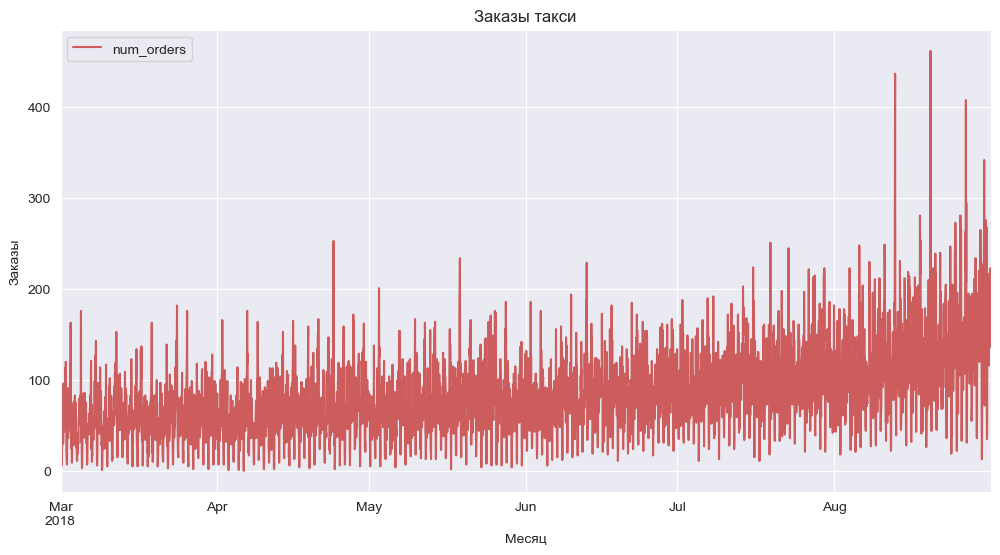

In [7]:
print(f'Размерность таблицы: {df.shape}\n\n\
Количество пропусков:\n{df.isna().sum()}\n\n\
Временной промежуток: {df.index.max() - df.index.min()}\n')

display(df.head(), 
        df.info(), 
        df.plot(color='indianred', title='Заказы такси', figsize=(12,6)), 
        names('Месяц', 'Заказы'))

<h3>Вывод

- Мы установили целевой признак `datetime` в качестве инекса таблицы
- Мы применили ресемплинг данных по одному часу
- В датафрейме 4416 наблюдений и 1 столбец — `num_orders`
- У нас есть данные за 183 дня и 23 часа — 6.1 месяцев
- Пропусков в данных нет

<h2>Анализ данных

Проанализируем данные:

- Создадим копию датасета
- Взглянем на график заказов по дням
- Взглянем на скользящее среднее
- Изучим тренд, сезонность и остаток в данных
- Найдем скользящее стандартное отклонение
- Сделаем временной ряд стационарным

In [8]:
df_copy = df.copy()

<h3>График заказов по дням

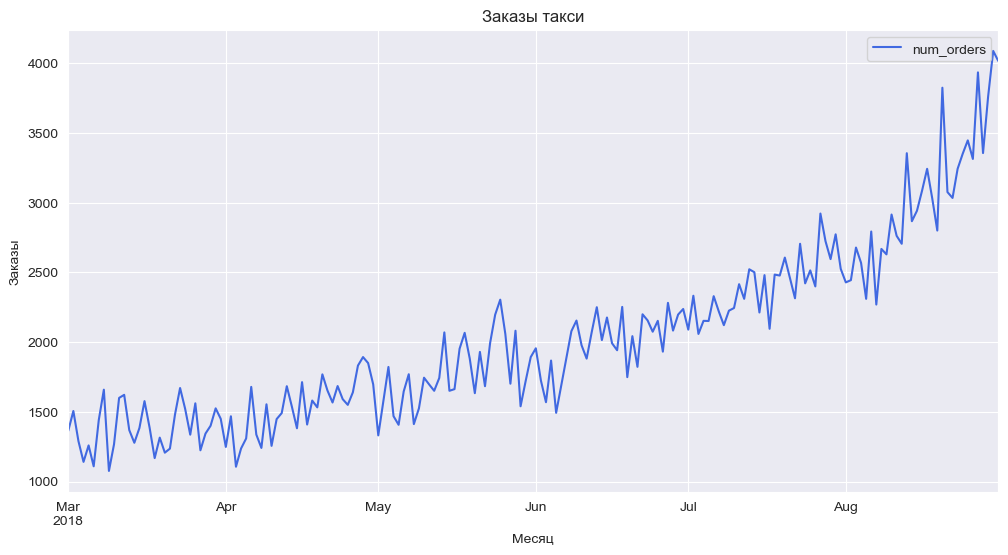

In [9]:
df_copy.resample('1D').sum().plot(color='royalblue', title='Заказы такси', figsize=(12,6))
names('Месяц', 'Заказы')

<h3>Скользящее среднее

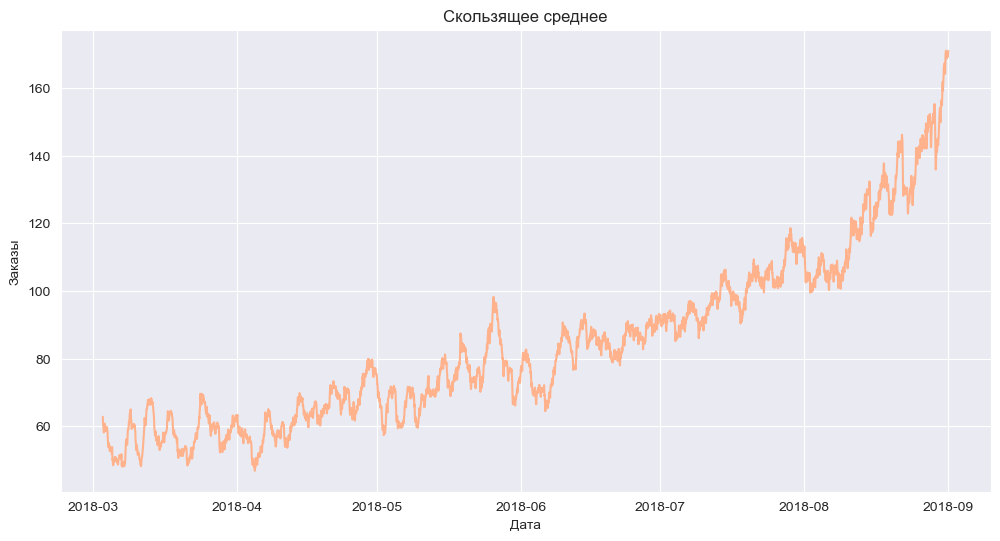

In [10]:
plt.figure(figsize=(12,6))

rolling_mean = df_copy.rolling(50).mean()

sns.lineplot(x=rolling_mean.index, y=rolling_mean.values.squeeze(), color='#FFB28B')
plt.title('Скользящее среднее')
names('Дата', 'Заказы')

<h3>Тренд, сезонность и остаток в данных

Взглянем на тренд, сезонность и остаток в данных.

In [11]:
decomposed = seasonal_decompose(df_copy)

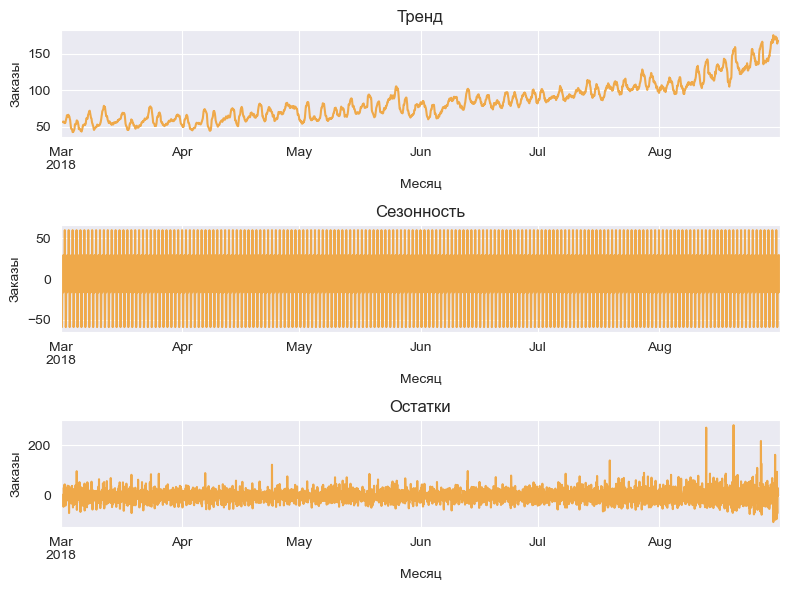

In [12]:
plt.figure(figsize=(8, 6))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='#EFA94A')
plt.title('Тренд')
names('Месяц', 'Заказы')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca(), color='#EFA94A') 
plt.title('Сезонность')
names('Месяц', 'Заказы')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca(), color='#EFA94A') 
plt.title('Остатки')
names('Месяц', 'Заказы')
plt.tight_layout()

Из графиков мало что понятно. Возьмем временной промежуток в неделю и взглянем на графики по нему.

In [13]:
decomposed = seasonal_decompose(df_copy['2018-05-07':'2018-05-13'])

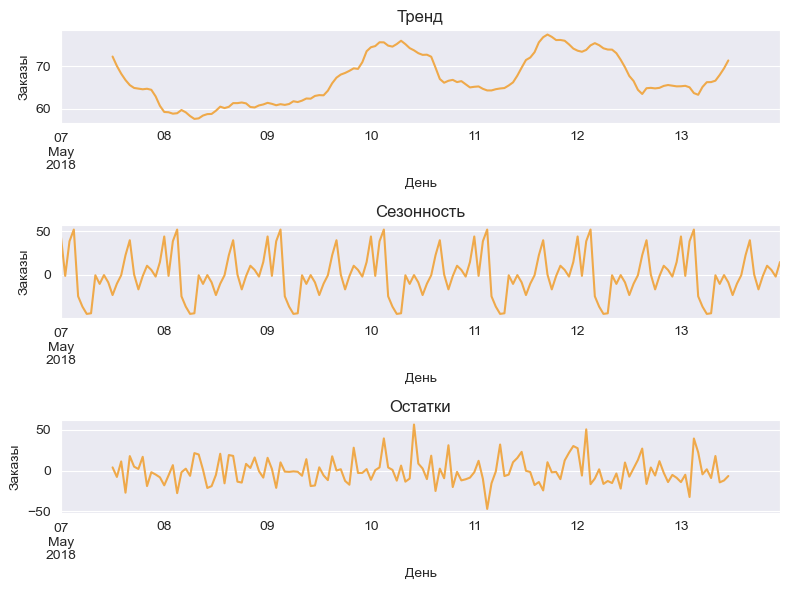

In [14]:
plt.figure(figsize=(8, 6))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='#EFA94A')
plt.title('Тренд')
names('День', 'Заказы')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca(), color='#EFA94A') 
plt.title('Сезонность')
names('День', 'Заказы')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca(), color='#EFA94A') 
plt.title('Остатки')
names('День', 'Заказы')
plt.tight_layout()

<h3>Скользящее стандартное отклонение

In [15]:
df_copy['mean'] = df_copy['num_orders'].rolling(30).mean()
df_copy['std'] = df_copy['num_orders'].rolling(30).std()

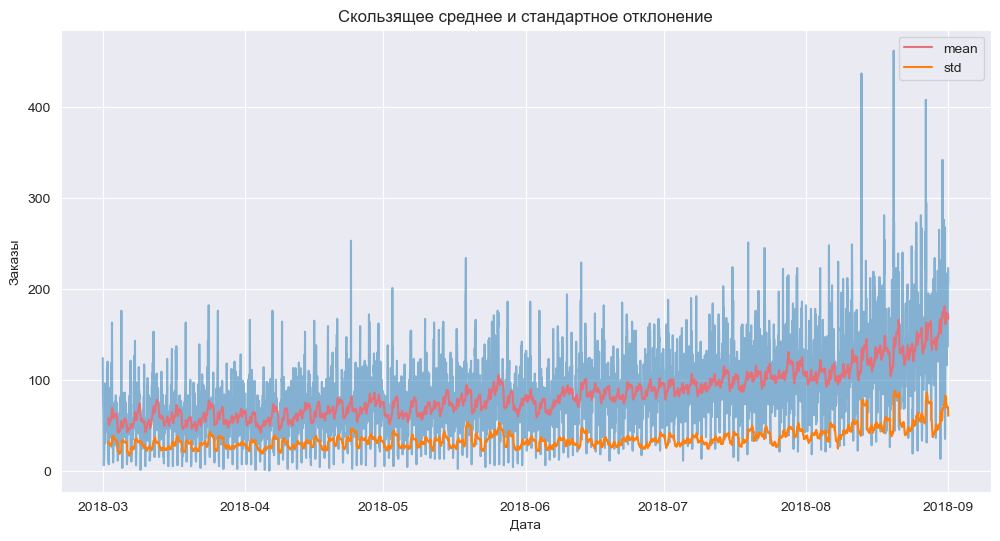

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_copy.index, y=df_copy['num_orders'], alpha=0.5)
sns.lineplot(x=df_copy.index, y=df_copy['mean'], label='mean', color='#E4717A')
sns.lineplot(x=df_copy.index, y=df_copy['std'], label='std', palette='blueviolet')
plt.title('Скользящее среднее и стандартное отклонение')
names('Дата', 'Заказы')

<h3>Разности временного ряда

In [17]:
df_copy = df_copy - df_copy.shift()
df_copy['mean'] = df_copy['num_orders'].rolling(25).mean()
df_copy['std'] = df_copy['num_orders'].rolling(25).std()

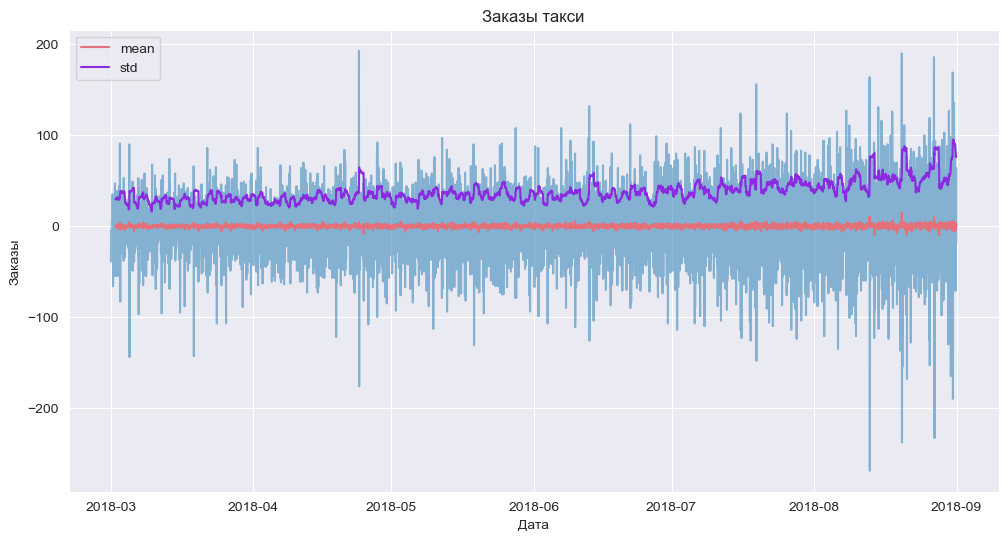

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_copy.index, y=df_copy['num_orders'], alpha=0.5)
sns.lineplot(x=df_copy.index, y=df_copy['mean'], label='mean', color='#E4717A')
sns.lineplot(x=df_copy.index, y=df_copy['std'], label='std', color='blueviolet')
plt.title('Заказы такси')
names('Дата', 'Заказы')

<h3>Вывод

- Дисперсия увеличичвается
- Заметен стабильный рост числа заказов с временными незначительными спадами. Это может говорить о постоянном росте интереса к продукции или расширении бизнеса в этом направлении
- Есть сезонные колебания: количество заказов уменьшается ночью, начинает расти утром и достигает максимума к вечеру. Такой рисунок, вероятно, связан с ритмом жизни клиентов и их активностью в разное время дня
- Нам необходимо будет добавить признаки `dayofweek`, `day` и `hour`

<h2>Модели

В блоке обучения моделей необходимо:

- Добавить новые признаки
- Разделить данные на тренировочную и тестовую выборки
- Создать функцию `RMSE`
- Оценить константную модель
- Подобрать лучшие гиперпараметры для моделей, оценить их с помощью кросс-валидации и выбрать лучшую модель
- Оценить лучшую модель на тестовой выборке

<h3>Признаки

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df_copy = df.copy()
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['day'] = df_copy.index.day
    df_copy['hour'] = df_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_copy.dropna()

In [20]:
data = make_features(df, 24, 12)
data.dropna(inplace=True)
data.head()

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,2,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333
2018-03-02 01:00:00,120,4,2,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.583333
2018-03-02 02:00:00,75,4,2,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,68.916667
2018-03-02 03:00:00,64,4,2,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.166667
2018-03-02 04:00:00,20,4,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.000000


<h3>Выборки

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=SEED)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [22]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test  = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3952, 28) (3952,)
(440, 28) (440,)


<h3>RMSE

In [23]:
def rmse(true, predicted):
    return np.sqrt(mse(true, predicted))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

<h3>Dummy модель

In [24]:
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predicted = dummy_clf.predict(features_test)
rmse(target_test, predicted)

84.68768287118466

<h3>Обучение моделей

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

In [26]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 8)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    clf = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features, 
        random_state=SEED)
    
    return -cross_val_score(clf, 
                            features_train, 
                            target_train, 
                            n_jobs=-1, 
                            cv=tscv, 
                            scoring=rmse_scorer).mean()

def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 0.0001, 1.0, log=True)
    
    clf = Lasso(alpha=alpha)
    
    return -cross_val_score(clf, 
                            features_train, 
                            target_train, 
                            n_jobs=-1, 
                            cv=tscv, 
                            scoring=rmse_scorer).mean()

def objective_lgbm(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 32, log=True)
    num_leaves = trial.suggest_int('num_leaves', 2, 100)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 200)
    
    clf = LGBMRegressor(
        learning_rate=learning_rate, n_estimators=n_estimators,
        max_depth=max_depth, num_leaves=num_leaves,
        min_child_samples=min_child_samples, 
        random_state=SEED)
    
    return -cross_val_score(clf, 
                            features_train, 
                            target_train, 
                            n_jobs=-1, 
                            cv=tscv, 
                            scoring=rmse_scorer).mean()

def objective_catboost(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 5, log=True)
    
    clf = CatBoostRegressor(
        learning_rate=learning_rate, n_estimators=n_estimators,
        max_depth=max_depth, l2_leaf_reg=l2_leaf_reg, verbose=0, random_state=SEED)
    
    return -cross_val_score(clf, 
                            features_train, 
                            target_train, 
                            n_jobs=-1, 
                            cv=tscv, 
                            scoring=rmse_scorer).mean()

def objective_linreg(trial):
    # LinearRegression не имеет гиперпараметров для настройки
    clf = LinearRegression()
    return -cross_val_score(clf, 
                            features_train, 
                            target_train,
                            n_jobs=-1, 
                            cv=tscv, 
                            scoring=rmse_scorer).mean()

In [27]:
# применяем optuna
study_names = ["RandomForest", "Lasso", "LGBM", "CatBoost", "LinearRegression"]
study_functions = [objective_rf, objective_lasso, objective_lgbm, objective_catboost, objective_linreg]
studies = {}

for study_name, study_func in zip(study_names, study_functions):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=SEED))
    study.optimize(study_func, n_trials=30)
    studies[study_name] = study

In [28]:
# создаем таблицу
results = []

for study_name, study in studies.items():
    results.append({
        "Model": study_name,
        "Best RMSE": study.best_value,
        "Best Params": study.best_params
    })

# Преобразуем список словарей в DataFrame
results_df = pd.DataFrame(results)

In [29]:
# Выводим DataFrame с результатами
results_df

,Model,Best RMSE,Best Params
0,RandomForest,25.460079,"{'n_estimators': 61, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}"
1,Lasso,27.123882,{'alpha': 0.9463642884490213}
2,LGBM,24.833492,"{'learning_rate': 0.13010081173995316, 'n_estimators': 239, 'max_depth': 3, 'num_leaves': 72, 'min_child_samples': 36}"
3,CatBoost,24.345322,"{'learning_rate': 0.0542027896011993, 'n_estimators': 362, 'max_depth': 5, 'l2_leaf_reg': 0.0756385645904796}"
4,LinearRegression,27.590591,{}


<h3>Итоговая модель

Лучший показатель `RMSE` оказался у `CatBoost`. Проверим модель на тестовой выборке и сравним на графиках, как близко или далеко оказались предсказания от истинных значений.

Оцениv модель предыдущим значением ряда.

In [30]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(rmse(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 58.882


In [31]:
model = CatBoostRegressor(learning_rate=0.0542027896011993,
                          max_depth=5,
                          n_estimators=362,
                          l2_leaf_reg=0.0756385645904796,
                          verbose=0,
                          random_state=SEED)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)

In [32]:
print(f'RMSE модели LGBMRegressor на тестовой выборке: {rmse(target_test, target_predict)}')

RMSE модели LGBMRegressor на тестовой выборке: 39.78733051523601


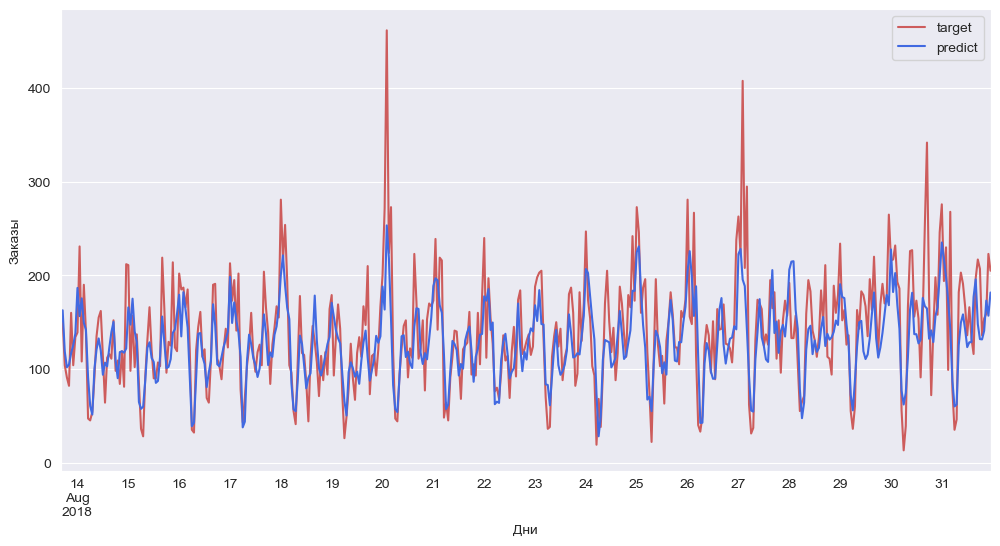

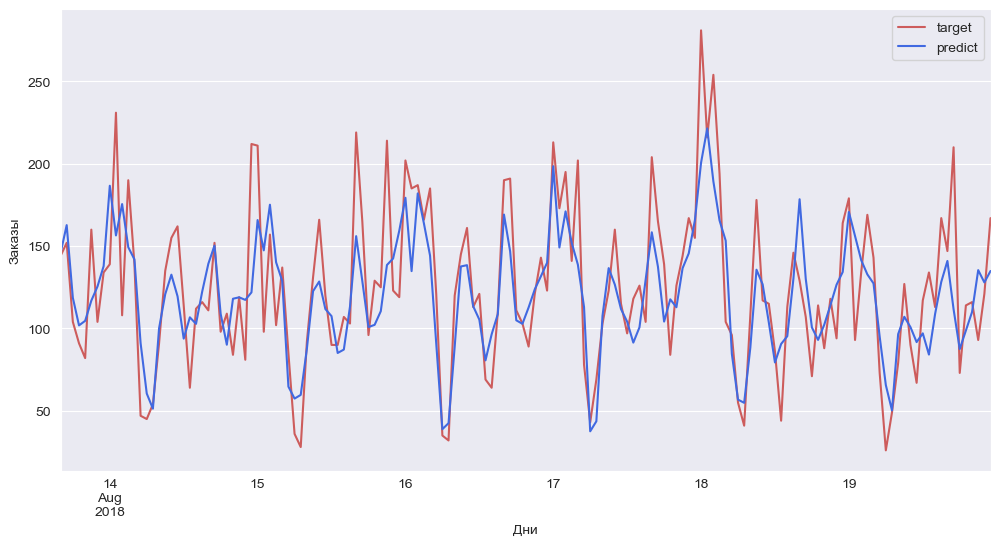

In [33]:
model_data = pd.DataFrame({"target":target_test, "predict":target_predict})
model_data.plot(figsize=(12, 6), color=['indianred', 'royalblue'])
names('Дни', 'Заказы')
model_data['2018-08-13':'2018-08-19'].plot(figsize=(12, 6), color=['indianred', 'royalblue'])
names('Дни', 'Заказы')

<h3>Вывод

В данном блоке мы:

- Добавили в таблицу новые признаки
- Создали тренировочную и тестовую выборки
- Оценили модели по значению `RMSE` на кросс-валидации с лучшими гиперпараметрами, подобранными `optuna`
- Выбрали `LGBMRegressor` как лучшую модель и оценили её на тестовой выборке, получив `RMSE` = 39.7
- Увидели, что модель не предсказывает больше чем 300 заказов

<h2>Итоговый вывод

Целью нашего проекта было построение модели машинного обучения, которая могла бы спрогнозировать количество заказов такси на следующий час.

По ходу проекта мы:

- Загрузили и изучили данные
- Провели анализ данных и выявили некоторые особенности:
    - Заметен стабильный рост числа заказов с временными незначительными спадами. Это может говорить о постоянном росте интереса к продукции или расширении бизнеса в этом направлении
    - Есть сезонные колебания: количество заказов уменьшается ночью, начинает расти утром и достигает максимума к вечеру. Такой рисунок, вероятно, скорее всего связан с ритмом жизни клиентов и их активностью в разное время дня
- Изучили несколько моделей на тренировочной выборке:
    - Lasso
    - LinearRegression
    - RandomForest
    - LGBM
    - CatBoost
- Лучший результат показала модель CatBoost. Проверили её на тестовой выборке и получили RMSE = 39.7, что удовлетворяет поставленному максимальному порогу значения

В итоге можем порекомендовать компании «Чётенькое такси» использовать модель `CatBoostRegressor` для прогноза количества заказов такси на следующий час.